In [4]:
# encoding:utf-8

'''
	Solution for Travelling Salesman Problem using PSO (Particle Swarm Optimization)
	Discrete PSO for TSP

	References: 
		http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.258.7026&rep=rep1&type=pdf
		http://www.cs.mun.ca/~tinayu/Teaching_files/cs4752/Lecture19_new.pdf
		http://www.swarmintelligence.org/tutorials.php

	References are in the folder "references" of the repository.
'''

from operator import attrgetter
import random, sys, time, copy


# class that represents a graph
class Graph:

	def __init__(self, amount_vertices):
		self.edges = {} # dictionary of edges
		self.vertices = set() # set of vertices
		self.amount_vertices = amount_vertices # amount of vertices


	# adds a edge linking "src" in "dest" with a "cost"
	def addEdge(self, src, dest, cost = 0):
		# checks if the edge already exists
		if not self.existsEdge(src, dest):
			self.edges[(src, dest)] = cost
			self.vertices.add(src)
			self.vertices.add(dest)


	# checks if exists a edge linking "src" in "dest"
	def existsEdge(self, src, dest):
		return (True if (src, dest) in self.edges else False)


	# shows all the links of the graph
	def showGraph(self):
		print('Showing the graph:\n')
		for edge in self.edges:
			print('%d linked in %d with cost %d' % (edge[0], edge[1], self.edges[edge]))

	# returns total cost of the path
	def getCostPath(self, path):
		
		total_cost = 0
		for i in range(self.amount_vertices - 1):
			total_cost += self.edges[(path[i], path[i+1])]

		# add cost of the last edge
		total_cost += self.edges[(path[self.amount_vertices - 1], path[0])]
		return total_cost


	# gets random unique paths - returns a list of lists of paths
	def getRandomPaths(self, max_size):

		random_paths, list_vertices = [], list(self.vertices)

		initial_vertice = random.choice(list_vertices)
		if initial_vertice not in list_vertices:
			print('Error: initial vertice %d not exists!' % initial_vertice)
			sys.exit(1)

		list_vertices.remove(initial_vertice)
		list_vertices.insert(0, initial_vertice)

		for i in range(max_size):
			list_temp = list_vertices[1:]
			random.shuffle(list_temp)
			list_temp.insert(0, initial_vertice)

			if list_temp not in random_paths:
				random_paths.append(list_temp)

		return random_paths


# class that represents a complete graph
class CompleteGraph(Graph):

	# generates a complete graph
	def generates(self):
		for i in range(self.amount_vertices):
			for j in range(self.amount_vertices):
				if i != j:
					weight = random.randint(1, 10)
					self.addEdge(i, j, weight)


# class that represents a particle
class Particle:

	def __init__(self, solution, cost):

		# current solution
		self.solution = solution

		# best solution (fitness) it has achieved so far
		self.pbest = solution

		# set costs
		self.cost_current_solution = cost
		self.cost_pbest_solution = cost

		# velocity of a particle is a sequence of 4-tuple
		# (1, 2, 1, 'beta') means SO(1,2), prabability 1 and compares with "beta"
		self.velocity = []

	# set pbest
	def setPBest(self, new_pbest):
		self.pbest = new_pbest

	# returns the pbest
	def getPBest(self):
		return self.pbest

	# set the new velocity (sequence of swap operators)
	def setVelocity(self, new_velocity):
		self.velocity = new_velocity

	# returns the velocity (sequence of swap operators)
	def getVelocity(self):
		return self.velocity

	# set solution
	def setCurrentSolution(self, solution):
		self.solution = solution

	# gets solution
	def getCurrentSolution(self):
		return self.solution

	# set cost pbest solution
	def setCostPBest(self, cost):
		self.cost_pbest_solution = cost

	# gets cost pbest solution
	def getCostPBest(self):
		return self.cost_pbest_solution

	# set cost current solution
	def setCostCurrentSolution(self, cost):
		self.cost_current_solution = cost

	# gets cost current solution
	def getCostCurrentSolution(self):
		return self.cost_current_solution

	# removes all elements of the list velocity
	def clearVelocity(self):
		del self.velocity[:]


# PSO algorithm
class PSO:

	def __init__(self, graph, iterations, size_population, beta=1, alfa=1):
		self.graph = graph # the graph
		self.iterations = iterations # max of iterations
		self.size_population = size_population # size population
		self.particles = [] # list of particles
		self.beta = beta # the probability that all swap operators in swap sequence (gbest - x(t-1))
		self.alfa = alfa # the probability that all swap operators in swap sequence (pbest - x(t-1))

		# initialized with a group of random particles (solutions)
		solutions = self.graph.getRandomPaths(self.size_population)

		# checks if exists any solution
		if not solutions:
			print('Initial population empty! Try run the algorithm again...')
			sys.exit(1)

		# creates the particles and initialization of swap sequences in all the particles
		for solution in solutions:
			# creates a new particle
			particle = Particle(solution=solution, cost=graph.getCostPath(solution))
			# add the particle
			self.particles.append(particle)

		# updates "size_population"
		self.size_population = len(self.particles)


	# set gbest (best particle of the population)
	def setGBest(self, new_gbest):
		self.gbest = new_gbest

	# returns gbest (best particle of the population)
	def getGBest(self):
		return self.gbest


	# shows the info of the particles
	def showsParticles(self):

		print('Showing particles...\n')
		for particle in self.particles:
			print('pbest: %s\t|\tcost pbest: %d\t|\tcurrent solution: %s\t|\tcost current solution: %d' \
				% (str(particle.getPBest()), particle.getCostPBest(), str(particle.getCurrentSolution()),
							particle.getCostCurrentSolution()))
		print('')


	def run(self):

		# for each time step (iteration)
		for t in range(self.iterations):

			# updates gbest (best particle of the population)
			self.gbest = min(self.particles, key=attrgetter('cost_pbest_solution'))

			# for each particle in the swarm
			for particle in self.particles:

				particle.clearVelocity() # cleans the speed of the particle
				temp_velocity = []
				solution_gbest = copy.copy(self.gbest.getPBest()) # gets solution of the gbest
				solution_pbest = particle.getPBest()[:] # copy of the pbest solution
				solution_particle = particle.getCurrentSolution()[:] # gets copy of the current solution of the particle

				# generates all swap operators to calculate (pbest - x(t-1))
				for i in range(self.graph.amount_vertices):
					if solution_particle[i] != solution_pbest[i]:
						# generates swap operator
						swap_operator = (i, solution_pbest.index(solution_particle[i]), self.alfa)

						# append swap operator in the list of velocity
						temp_velocity.append(swap_operator)

						# makes the swap
						aux = solution_pbest[swap_operator[0]]
						solution_pbest[swap_operator[0]] = solution_pbest[swap_operator[1]]
						solution_pbest[swap_operator[1]] = aux

				# generates all swap operators to calculate (gbest - x(t-1))
				for i in range(self.graph.amount_vertices):
					if solution_particle[i] != solution_gbest[i]:
						# generates swap operator
						swap_operator = (i, solution_gbest.index(solution_particle[i]), self.beta)

						# append swap operator in the list of velocity
						temp_velocity.append(swap_operator)

						# makes the swap
						aux = solution_gbest[swap_operator[0]]
						solution_gbest[swap_operator[0]] = solution_gbest[swap_operator[1]]
						solution_gbest[swap_operator[1]] = aux

				
				# updates velocity
				particle.setVelocity(temp_velocity)

				# generates new solution for particle
				for swap_operator in temp_velocity:
					if random.random() <= swap_operator[2]:
						# makes the swap
						aux = solution_particle[swap_operator[0]]
						solution_particle[swap_operator[0]] = solution_particle[swap_operator[1]]
						solution_particle[swap_operator[1]] = aux
				
				# updates the current solution
				particle.setCurrentSolution(solution_particle)
				# gets cost of the current solution
				cost_current_solution = self.graph.getCostPath(solution_particle)
				# updates the cost of the current solution
				particle.setCostCurrentSolution(cost_current_solution)

				# checks if current solution is pbest solution
				if cost_current_solution < particle.getCostPBest():
					particle.setPBest(solution_particle)
					particle.setCostPBest(cost_current_solution)
		

if __name__ == "__main__":
	
	# creates the Graph instance
	graph = Graph(amount_vertices=5)

	# This graph is in the folder "images" of the repository.
	graph.addEdge(0, 1, 1)
	graph.addEdge(1, 0, 1)
	graph.addEdge(0, 2, 3)
	graph.addEdge(2, 0, 3)
	graph.addEdge(0, 3, 4)
	graph.addEdge(3, 0, 4)
	graph.addEdge(0, 4, 5)
	graph.addEdge(4, 0, 5)
	graph.addEdge(1, 2, 1)
	graph.addEdge(2, 1, 1)
	graph.addEdge(1, 3, 4)
	graph.addEdge(3, 1, 4)
	graph.addEdge(1, 4, 8)
	graph.addEdge(4, 1, 8)
	graph.addEdge(2, 3, 5)
	graph.addEdge(3, 2, 5)
	graph.addEdge(2, 4, 1)
	graph.addEdge(4, 2, 1)
	graph.addEdge(3, 4, 2)
	graph.addEdge(4, 3, 2)

	# creates a PSO instance
	pso = PSO(graph, iterations=100, size_population=10, beta=1, alfa=0.9)
	pso.run() # runs the PSO algorithm
	pso.showsParticles() # shows the particles

	# shows the global best particle
	print('gbest: %s | cost: %d\n' % (pso.getGBest().getPBest(), pso.getGBest().getCostPBest()))

	
	# random graph
	print('Random graph...')
	random_graph = CompleteGraph(amount_vertices=20)
	random_graph.generates()
	pso_random_graph = PSO(random_graph, iterations=10000, size_population=10, beta=1, alfa=1)
	pso_random_graph.run()
	print('gbest: %s | cost: %d\n' % (pso_random_graph.getGBest().getPBest(), 
					pso_random_graph.getGBest().getCostPBest()))


Showing particles...

pbest: [1, 2, 4, 3, 0]	|	cost pbest: 9	|	current solution: [1, 2, 4, 3, 0]	|	cost current solution: 9
pbest: [1, 2, 4, 3, 0]	|	cost pbest: 9	|	current solution: [1, 2, 4, 3, 0]	|	cost current solution: 9
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 4, 3, 2]	|	cost current solution: 14
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 4, 3, 2]	|	cost current solution: 14
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 2, 4, 3, 0]	|	cost current solution: 9
pbest: [1, 2, 4, 3, 0]	|	cost pbest: 9	|	current solution: [1, 2, 4, 3, 0]	|	cost current solution: 9
pbest: [1, 2, 4, 3, 0]	|	cost pbest: 9	|	current solution: [1, 2, 4, 3, 0]	|	cost current solution: 9
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 4, 3, 2]	|	cost current solution: 14

gbest: [1, 2, 4, 3, 0] | cost: 9

Random graph...
gbest: [6, 7, 8, 16, 19, 2, 14, 12, 3, 11, 15, 13, 4, 0, 5, 10, 9, 17, 1, 18] | cost: 66



Showing particles...

pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 3, 4, 2]	|	cost current solution: 9
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 3, 4, 2]	|	cost current solution: 9
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 3, 4, 2]	|	cost current solution: 9
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 3, 4, 2]	|	cost current solution: 9
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 3, 4, 2]	|	cost current solution: 9
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 3, 4, 2]	|	cost current solution: 9
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 3, 4, 2]	|	cost current solution: 9
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 3, 4, 2]	|	cost current solution: 9
pbest: [1, 0, 3, 4, 2]	|	cost pbest: 9	|	current solution: [1, 0, 3, 4, 2]	|	cost current solution: 9

gbest: [1, 0, 3, 4, 2] | cost: 9



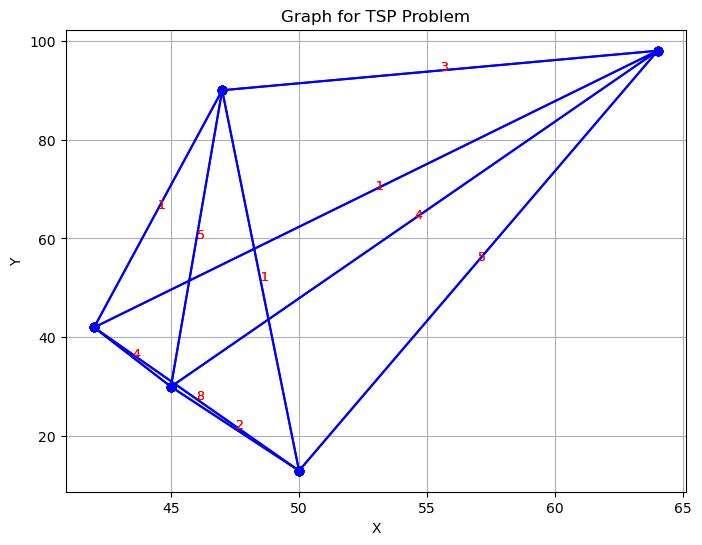

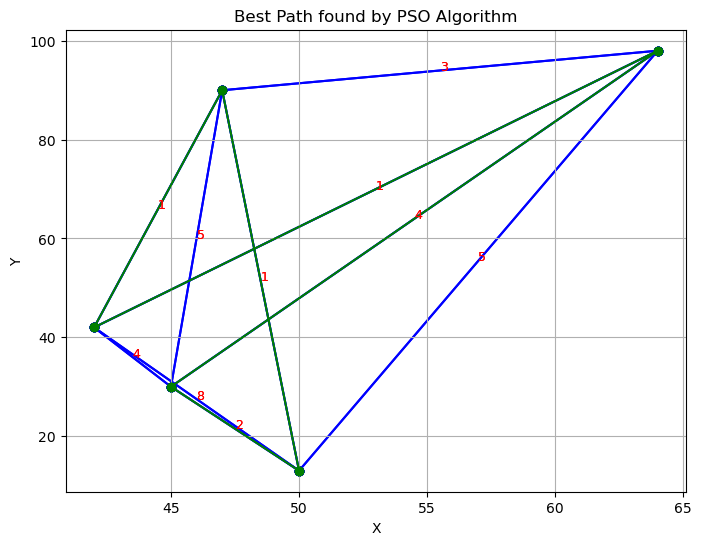

In [3]:
import random
import copy
from operator import attrgetter
import sys
import matplotlib.pyplot as plt

class Graph:

    def __init__(self, amount_vertices):
        self.edges = {}  # dictionnaire des arêtes
        self.vertices = {}  # dictionnaire des coordonnées des sommets
        self.amount_vertices = amount_vertices  # nombre de sommets

    # Ajoute une arête reliant "src" à "dest" avec un "coût"
    def addEdge(self, src, dest, cost=0):
        # Vérifie si l'arête existe déjà
        if not self.existsEdge(src, dest):
            self.edges[(src, dest)] = cost
            self.vertices[src] = (random.randint(0, 100), random.randint(0, 100))  # Coordonnées aléatoires pour les sommets
            self.vertices[dest] = (random.randint(0, 100), random.randint(0, 100))

    # Vérifie si une arête reliant "src" à "dest" existe
    def existsEdge(self, src, dest):
        return (True if (src, dest) in self.edges else False)

    # shows all the links of the graph
    def showGraph(self):
        print('Showing the graph:\n')
        for edge in self.edges:
            print('%d linked in %d with cost %d' % (edge[0], edge[1], self.edges[edge]))

    # returns total cost of the path
    def getCostPath(self, path):
        total_cost = 0
        for i in range(self.amount_vertices - 1):
            total_cost += self.edges[(path[i], path[i+1])]

        # add cost of the last edge
        total_cost += self.edges[(path[self.amount_vertices - 1], path[0])]
        return total_cost

    # gets random unique paths - returns a list of lists of paths
    def getRandomPaths(self, max_size):
        random_paths, list_vertices = [], list(self.vertices)

        initial_vertice = random.choice(list_vertices)
        if initial_vertice not in list_vertices:
            print('Error: initial vertice %d not exists!' % initial_vertice)
            sys.exit(1)

        list_vertices.remove(initial_vertice)
        list_vertices.insert(0, initial_vertice)

        for i in range(max_size):
            list_temp = list_vertices[1:]
            random.shuffle(list_temp)
            list_temp.insert(0, initial_vertice)

            if list_temp not in random_paths:
                random_paths.append(list_temp)

        return random_paths


# class that represents a complete graph
class CompleteGraph(Graph):

    # generates a complete graph
    def generates(self):
        for i in range(self.amount_vertices):
            for j in range(self.amount_vertices):
                if i != j:
                    weight = random.randint(1, 10)
                    self.addEdge(i, j, weight)


# class that represents a particle
class Particle:

    def __init__(self, solution, cost):

        # current solution
        self.solution = solution

        # best solution (fitness) it has achieved so far
        self.pbest = solution

        # set costs
        self.cost_current_solution = cost
        self.cost_pbest_solution = cost

        # velocity of a particle is a sequence of 4-tuple
        # (1, 2, 1, 'beta') means SO(1,2), prabability 1 and compares with "beta"
        self.velocity = []

    # set pbest
    def setPBest(self, new_pbest):
        self.pbest = new_pbest

    # returns the pbest
    def getPBest(self):
        return self.pbest

    # set the new velocity (sequence of swap operators)
    def setVelocity(self, new_velocity):
        self.velocity = new_velocity

    # returns the velocity (sequence of swap operators)
    def getVelocity(self):
        return self.velocity

    # set solution
    def setCurrentSolution(self, solution):
        self.solution = solution

    # gets solution
    def getCurrentSolution(self):
        return self.solution

    # set cost pbest solution
    def setCostPBest(self, cost):
        self.cost_pbest_solution = cost

    # gets cost pbest solution
    def getCostPBest(self):
        return self.cost_pbest_solution

    # set cost current solution
    def setCostCurrentSolution(self, cost):
        self.cost_current_solution = cost

    # gets cost current solution
    def getCostCurrentSolution(self):
        return self.cost_current_solution

    # removes all elements of the list velocity
    def clearVelocity(self):
        del self.velocity[:]


# PSO algorithm
class PSO:

    def __init__(self, graph, iterations, size_population, beta=1, alfa=1):
        self.graph = graph # the graph
        self.iterations = iterations # max of iterations
        self.size_population = size_population # size population
        self.particles = [] # list of particles
        self.beta = beta # the probability that all swap operators in swap sequence (gbest - x(t-1))
        self.alfa = alfa # the probability that all swap operators in swap sequence (pbest - x(t-1))

        # initialized with a group of random particles (solutions)
        solutions = self.graph.getRandomPaths(self.size_population)

        # checks if exists any solution
        if not solutions:
            print('Initial population empty! Try run the algorithm again...')
            sys.exit(1)

        # creates the particles and initialization of swap sequences in all the particles
        for solution in solutions:
            # creates a new particle
            particle = Particle(solution=solution, cost=graph.getCostPath(solution))
            # add the particle
            self.particles.append(particle)

        # updates "size_population"
        self.size_population = len(self.particles)


    # set gbest (best particle of the population)
    def setGBest(self, new_gbest):
        self.gbest = new_gbest

    # returns gbest (best particle of the population)
    def getGBest(self):
        return self.gbest

    # shows the info of the particles
    def showsParticles(self):
        print('Showing particles...\n')
        for particle in self.particles:
            print('pbest: %s\t|\tcost pbest: %d\t|\tcurrent solution: %s\t|\tcost current solution: %d' \
                % (str(particle.getPBest()), particle.getCostPBest(), str(particle.getCurrentSolution()),
                            particle.getCostCurrentSolution()))
        print('')

    def run(self):
        # for each time step (iteration)
        for t in range(self.iterations):
            # updates gbest (best particle of the population)
            self.gbest = min(self.particles, key=attrgetter('cost_pbest_solution'))
            # for each particle in the swarm
            for particle in self.particles:
                particle.clearVelocity() # cleans the speed of the particle
                temp_velocity = []
                solution_gbest = copy.copy(self.gbest.getPBest()) # gets solution of the gbest
                solution_pbest = particle.getPBest()[:] # copy of the pbest solution
                solution_particle = particle.getCurrentSolution()[:] # gets copy of the current solution of the particle

                # generates all swap operators to calculate (pbest - x(t-1))
                for i in range(self.graph.amount_vertices):
                    if solution_particle[i] != solution_pbest[i]:
                        # generates swap operator
                        swap_operator = (i, solution_pbest.index(solution_particle[i]), self.alfa)
                        # append swap operator in the list of velocity
                        temp_velocity.append(swap_operator)
                        # makes the swap
                        aux = solution_pbest[swap_operator[0]]
                        solution_pbest[swap_operator[0]] = solution_pbest[swap_operator[1]]
                        solution_pbest[swap_operator[1]] = aux

                # generates all swap operators to calculate (gbest - x(t-1))
                for i in range(self.graph.amount_vertices):
                    if solution_particle[i] != solution_gbest[i]:
                        # generates swap operator
                        swap_operator = (i, solution_gbest.index(solution_particle[i]), self.beta)
                        # append swap operator in the list of velocity
                        temp_velocity.append(swap_operator)
                        # makes the swap
                        aux = solution_gbest[swap_operator[0]]
                        solution_gbest[swap_operator[0]] = solution_gbest[swap_operator[1]]
                        solution_gbest[swap_operator[1]] = aux

                # updates velocity
                particle.setVelocity(temp_velocity)

                # generates new solution for particle
                for swap_operator in temp_velocity:
                    if random.random() <= swap_operator[2]:
                        # makes the swap
                        aux = solution_particle[swap_operator[0]]
                        solution_particle[swap_operator[0]] = solution_particle[swap_operator[1]]
                        solution_particle[swap_operator[1]] = aux
                
                # updates the current solution
                particle.setCurrentSolution(solution_particle)
                # gets cost of the current solution
                cost_current_solution = self.graph.getCostPath(solution_particle)
                # updates the cost of the current solution
                particle.setCostCurrentSolution(cost_current_solution)

                # checks if current solution is pbest solution
                if cost_current_solution < particle.getCostPBest():
                    particle.setPBest(solution_particle)
                    particle.setCostPBest(cost_current_solution)


if __name__ == "__main__":
    
    # creates the Graph instance
    graph = Graph(amount_vertices=5)

    # This graph is in the folder "images" of the repository.
    graph.addEdge(0, 1, 1)
    graph.addEdge(1, 0, 1)
    graph.addEdge(0, 2, 3)
    graph.addEdge(2, 0, 3)
    graph.addEdge(0, 3, 4)
    graph.addEdge(3, 0, 4)
    graph.addEdge(0, 4, 5)
    graph.addEdge(4, 0, 5)
    graph.addEdge(1, 2, 1)
    graph.addEdge(2, 1, 1)
    graph.addEdge(1, 3, 4)
    graph.addEdge(3, 1, 4)
    graph.addEdge(1, 4, 8)
    graph.addEdge(4, 1, 8)
    graph.addEdge(2, 3, 5)
    graph.addEdge(3, 2, 5)
    graph.addEdge(2, 4, 1)
    graph.addEdge(4, 2, 1)
    graph.addEdge(3, 4, 2)
    graph.addEdge(4, 3, 2)

    # creates a PSO instance
    pso = PSO(graph, iterations=100, size_population=10, beta=1, alfa=0.9)
    pso.run() # runs the PSO algorithm
    pso.showsParticles() # shows the particles

    # shows the global best particle
    print('gbest: %s | cost: %d\n' % (pso.getGBest().getPBest(), pso.getGBest().getCostPBest()))

    
''''    # random graph
    print('Random graph...')
    random_graph = CompleteGraph(amount_vertices=10)
    random_graph.generates()
    pso_random_graph = PSO(random_graph, iterations=10000, size_population=10, beta=1, alfa=1)
    pso_random_graph.run()
    print('gbest: %s | cost: %d\n' % (pso_random_graph.getGBest().getPBest(), 
                    pso_random_graph.getGBest().getCostPBest()))'''

def plot_graph(graph, title="Graph"):
    plt.figure(figsize=(8, 6))
    for edge, cost in graph.edges.items():
        x1, y1 = graph.vertices[edge[0]]
        x2, y2 = graph.vertices[edge[1]]
        plt.plot([x1, x2], [y1, y2], marker='o', color='b')
        plt.text((x1 + x2) / 2, (y1 + y2) / 2, str(cost), fontsize=9, color='r')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

# Afficher le graphe initial du problème TSP
plot_graph(graph, title="Graph for TSP Problem")

def plot_best_path(graph, best_path, title="Best Path"):
    plt.figure(figsize=(8, 6))
    for edge, cost in graph.edges.items():
        x1, y1 = graph.vertices[edge[0]]
        x2, y2 = graph.vertices[edge[1]]
        plt.plot([x1, x2], [y1, y2], marker='o', color='b', zorder=1)
        plt.text((x1 + x2) / 2, (y1 + y2) / 2, str(cost), fontsize=9, color='r')
    for i in range(len(best_path) - 1):
        x1, y1 = graph.vertices[best_path[i]]
        x2, y2 = graph.vertices[best_path[i+1]]
        plt.plot([x1, x2], [y1, y2], marker='o', color='g', zorder=2)  # Best Path in green
    x1, y1 = graph.vertices[best_path[-1]]
    x2, y2 = graph.vertices[best_path[0]]
    plt.plot([x1, x2], [y1, y2], marker='o', color='g', zorder=2)  # Closing the loop
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

# Afficher le meilleur chemin trouvé par l'algorithme PSO
best_path = pso.getGBest().getPBest()
plot_best_path(graph, best_path, title="Best Path found by PSO Algorithm")

